## AdaMLS : Object Detection Running Example : Cluster Analysis : Rules

In [1]:
import warnings
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import StreamingKMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import StreamingKMeans
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans

In [2]:
# Read the data
dfn = pd.read_csv('detection_results_nano.txt')
dfs = pd.read_csv('detection_results_small.txt')
dfm = pd.read_csv('detection_results_medium.txt')
dfl = pd.read_csv('detection_results_large.txt')
dfx = pd.read_csv('detection_results_xlarge.txt')

# Read the K values
k_values_df = pd.read_csv('k_values.csv')

# Prepare a list of dataframes and their corresponding K values
dataframes = [
    (dfn, k_values_df.loc[k_values_df['model'] == 'Yolov5 Nano', 'k_value'].values[0]),
    (dfs, k_values_df.loc[k_values_df['model'] == 'Yolov5 Small', 'k_value'].values[0]),
    (dfm, k_values_df.loc[k_values_df['model'] == 'Yolov5 Medium', 'k_value'].values[0]),
    (dfl, k_values_df.loc[k_values_df['model'] == 'Yolov5 Large', 'k_value'].values[0]),
    (dfx, k_values_df.loc[k_values_df['model'] == 'Yolov5 Xlarge', 'k_value'].values[0]),
]

23/05/29 17:48:34 WARN StreamingContext: StreamingContext has not been started yet


Index(['Response Time(s)', 'SKMeans_Cluster'], dtype='object')


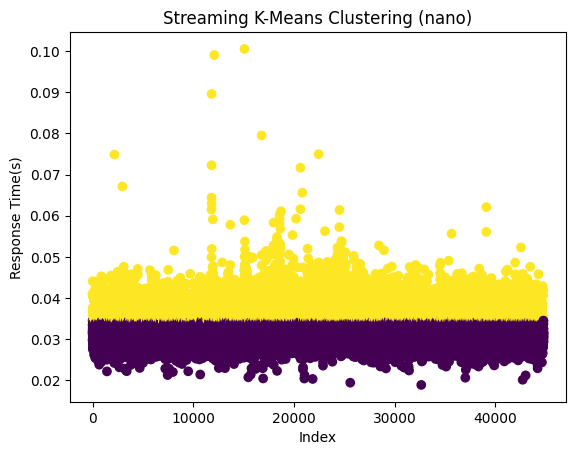

23/05/29 17:48:44 WARN StreamingContext: StreamingContext has not been started yet


Index(['Response Time(s)', 'SKMeans_Cluster'], dtype='object')


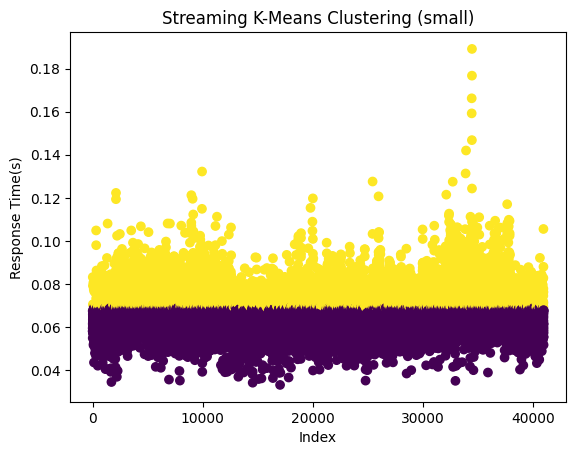

23/05/29 17:48:53 WARN StreamingContext: StreamingContext has not been started yet


Index(['Response Time(s)', 'SKMeans_Cluster'], dtype='object')


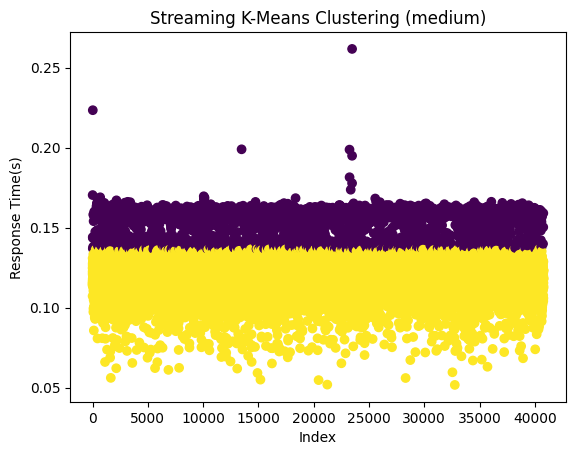

23/05/29 17:49:02 WARN StreamingContext: StreamingContext has not been started yet


Index(['Response Time(s)', 'SKMeans_Cluster'], dtype='object')


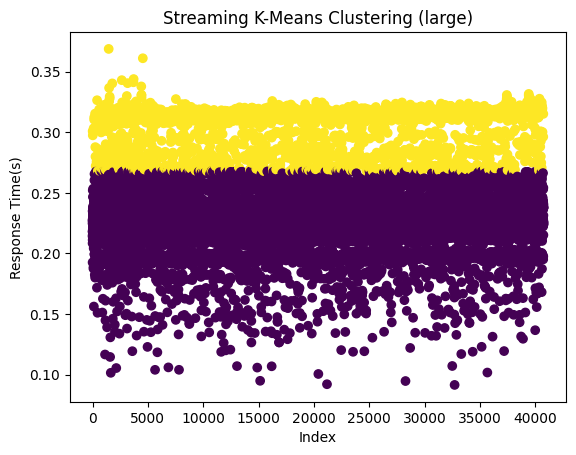

23/05/29 17:49:12 WARN StreamingContext: StreamingContext has not been started yet


Index(['Response Time(s)', 'SKMeans_Cluster'], dtype='object')


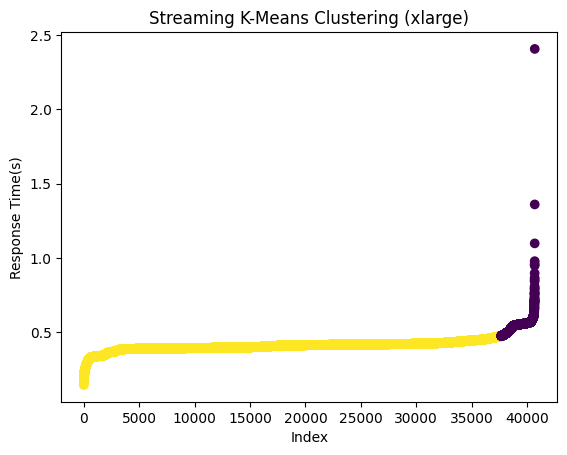

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import StreamingKMeans
import time
import pickle

# Import warnings module and filter warnings
warnings.filterwarnings("ignore")

# Initialize a SparkSessiondfn = pd.read_csv('detection_results_nano.txt')
spark = SparkSession.builder \
    .appName("Streaming K-means clustering") \
    .getOrCreate()

# Create an RDD from the historical data
def create_rdd_from_dataframe(df):
    # Replace column names to avoid issues with Spark
    renamed_columns = {
        'Avg. Confidence': 'Avg_Confidence',
        'Response Time(s)': 'Response_Time'
    }
    df = df.rename(columns=renamed_columns)

    # Convert the Pandas dataframe to a Spark dataframe
    spark_df = spark.createDataFrame(df)

    # Extract features as an RDD of Vectors
    features_rdd = spark_df.rdd.map(lambda row: Vectors.dense([row.Response_Time]))
    return features_rdd


# Simulate streaming data by dividing the historical data into smaller batches
def simulate_streaming_data(rdd, batch_size=10000):
    rdd_count = rdd.count()
    rdd_list = []

    for i in range(0, rdd_count, batch_size):
        rdd_list.append(rdd.zipWithIndex().filter(lambda x: i <= x[1] < i + batch_size).keys())

    return rdd_list

# Train and update the Streaming K-means model
def train_streaming_kmeans_model(rdd_list, k, initial_centers):
    # Initialize Spark Streaming Context with a batch interval of 1 second
    ssc = StreamingContext(spark.sparkContext, 1)

    # Initialize Streaming K-means with the given initial centers
    skmeans = StreamingKMeans(k=k, decayFactor=1.0, timeUnit="batches")
    skmeans.setInitialCenters(initial_centers, [1.0] * len(initial_centers))

    # Simulate streaming data and train the model
    for rdd in rdd_list:
        rdd_queue = [rdd]
        dstream = ssc.queueStream(rdd_queue)
        skmeans.trainOn(dstream)
        time.sleep(1)

    # Stop the Streaming Context
    ssc.stop(stopSparkContext=False)

    # Return the trained Streaming K-means model
    return skmeans.latestModel()

# Store the dataframes and their respective K values
dataframes = [dfn, dfs, dfm, dfl, dfx]
k_values = k_values_df['k_value'].tolist()

# Process and save results for KMeans and MiniBatchKMeans
all_models_data = [dfn, dfs, dfm, dfl, dfx]
model_names = ['nano', 'small', 'medium', 'large', 'xlarge']


# Perform clustering for each dataset
def perform_clustering(df, k, model_name):
    rdd_data = create_rdd_from_dataframe(df)
    rdd_list = simulate_streaming_data(rdd_data, batch_size=10000)

    # Initialize the cluster centers using K-means clustering
    kmeans_model = KMeans.train(rdd_data, k)
    initial_centers = kmeans_model.clusterCenters

    # Train the Streaming K-means model using the initial centers
    skmeans_model = train_streaming_kmeans_model(rdd_list, k, initial_centers)

    # Assign clusters to the data points
    clustered_data = rdd_data.map(lambda point: (point, skmeans_model.predict(point)))
    
    # Convert the results back to a Pandas DataFrame
    # Convert the results back to a Pandas DataFrame
    clustered_df = pd.DataFrame(clustered_data.map(lambda x: [x[0][0], x[1]]).collect(),
                                columns=['Response Time(s)', 'SKMeans_Cluster'])

    print(clustered_df.columns)
        # Add the 'Avg. Confidence' column to the clustered_df DataFrame
    clustered_df['Avg. Confidence'] = df['Avg. Confidence']

    # Merge the DataFrames on 'Avg. Confidence' and 'Response Time(s)'
    df = df.merge(clustered_df, on=['Avg. Confidence', 'Response Time(s)'])

    
    # Save the results as CSV files
    df.to_csv(f'{model_name}_SKMeans_Cluster.csv', index=False)

    # Plot the clusters
    plot_clusters(df, model_name, 'SKMeans_Cluster')
    
    return df

def plot_clusters(df, model_name, column):
    plt.scatter(df.index, df['Response Time(s)'], c=df[column], cmap='viridis')
    plt.title(f'Streaming K-Means Clustering ({model_name})')
    plt.xlabel('Index')
    plt.ylabel('Response Time(s)')
    plt.show()
    
# Store the dataframes and their respective K values
dataframes = [dfn, dfs, dfm, dfl, dfx]
k_values = k_values_df['k_value'].tolist()

# Function to add results from other models
def add_results_from_other_models(main_df, other_models_data, clustering_algo, model_names):
    for other_df, model_name in zip(other_models_data, model_names):
        other_df = other_df[['Image', 'Avg. Confidence', 'Response Time(s)', 'CPU Consumption(%)', 'Detection boxes', clustering_algo]]
        other_df.columns = [f'{col}_{model_name}' if col != 'Image' else col for col in other_df.columns]
        main_df = main_df.merge(other_df, left_on='Image', right_on='Image', how='outer')

    return main_df

# Process and save results for KMeans and MiniBatchKMeans
all_models_data = [dfn, dfs, dfm, dfl, dfx]
model_names = ['nano', 'small', 'medium', 'large', 'xlarge']

# Perform clustering and create CSV files for each model
for df, k, model_name in zip(dataframes, k_values, model_names):
    perform_clustering(df, k, model_name)

#### Saving the clustering results mapped with all other models for each model under consideration based on image number

In [4]:
#Nano Model
import pandas as pd

# Read the data from the files
small_df = pd.read_csv('small_SKMeans_Cluster.csv')
nano_df = pd.read_csv('nano_SKMeans_Cluster.csv')
medium_df = pd.read_csv('medium_SKMeans_Cluster.csv')
large_df = pd.read_csv('large_SKMeans_Cluster.csv')
xlarge_df = pd.read_csv('xlarge_SKMeans_Cluster.csv')

# List of dataframes and suffixes
dataframes = [nano_df, small_df, medium_df, large_df, xlarge_df]
suffixes = ['', '_small', '_medium', '_large', '_xlarge']

# Function to merge dataframes based on the "Image" column
def merge_dataframes(df1, df2, suffix):
    return df1.merge(df2, on='Image', suffixes=('', suffix))

# Create merged dataframes
merged_nano = nano_df.copy()
for df, suffix in zip(dataframes[1:], suffixes[1:]):
    merged_nano = merge_dataframes(merged_nano, df, suffix)

# Save the merged dataframe as a new CSV file
merged_nano.to_csv('nano_skmeans_with_other_results.csv', index=False)

In [5]:
#Small Model
import pandas as pd

# Read the data from the files
small_df = pd.read_csv('small_SKMeans_Cluster.csv')
nano_df = pd.read_csv('nano_SKMeans_Cluster.csv')
medium_df = pd.read_csv('medium_SKMeans_Cluster.csv')
large_df = pd.read_csv('large_SKMeans_Cluster.csv')
xlarge_df = pd.read_csv('xlarge_SKMeans_Cluster.csv')

# List of dataframes and suffixes
dataframes = [small_df, nano_df, medium_df, large_df, xlarge_df]
suffixes = ['', '_nano', '_medium', '_large', '_xlarge']

# Function to merge dataframes based on the "Image" column
def merge_dataframes(df1, df2, suffix):
    return df1.merge(df2, on='Image', suffixes=('', suffix))

# Create merged dataframes
merged_small = small_df.copy()
for df, suffix in zip(dataframes[1:], suffixes[1:]):
    merged_small = merge_dataframes(merged_small, df, suffix)

# Save the merged dataframe as a new CSV file
merged_small.to_csv('small_skmeans_with_other_results.csv', index=False)

In [6]:
#Medium Model
import pandas as pd

# Read the data from the files
small_df = pd.read_csv('small_SKMeans_Cluster.csv')
nano_df = pd.read_csv('nano_SKMeans_Cluster.csv')
medium_df = pd.read_csv('medium_SKMeans_Cluster.csv')
large_df = pd.read_csv('large_SKMeans_Cluster.csv')
xlarge_df = pd.read_csv('xlarge_SKMeans_Cluster.csv')

# List of dataframes and suffixes
dataframes = [medium_df, nano_df, small_df, large_df, xlarge_df]
suffixes = ['', '_nano', '_small', '_large', '_xlarge']

# Function to merge dataframes based on the "Image" column
def merge_dataframes(df1, df2, suffix):
    return df1.merge(df2, on='Image', suffixes=('', suffix))

# Create merged dataframes
merged_medium = medium_df.copy()
for df, suffix in zip(dataframes[1:], suffixes[1:]):
    merged_medium = merge_dataframes(merged_medium, df, suffix)

# Save the merged dataframe as a new CSV file
merged_medium.to_csv('medium_skmeans_with_other_results.csv', index=False)

In [7]:
#Large Model
import pandas as pd

# Read the data from the files
small_df = pd.read_csv('small_SKMeans_Cluster.csv')
nano_df = pd.read_csv('nano_SKMeans_Cluster.csv')
medium_df = pd.read_csv('medium_SKMeans_Cluster.csv')
large_df = pd.read_csv('large_SKMeans_Cluster.csv')
xlarge_df = pd.read_csv('xlarge_SKMeans_Cluster.csv')

# List of dataframes and suffixes
dataframes = [large_df, nano_df, medium_df, small_df, xlarge_df]
suffixes = ['', '_nano', '_medium', '_small', '_xlarge']

# Function to merge dataframes based on the "Image" column
def merge_dataframes(df1, df2, suffix):
    return df1.merge(df2, on='Image', suffixes=('', suffix))

# Create merged dataframes
merged_large = large_df.copy()
for df, suffix in zip(dataframes[1:], suffixes[1:]):
    merged_large = merge_dataframes(merged_large, df, suffix)

# Save the merged dataframe as a new CSV file
merged_large.to_csv('large_skmeans_with_other_results.csv', index=False)

In [8]:
#Xlarge Model
import pandas as pd

# Read the data from the files
small_df = pd.read_csv('small_SKMeans_Cluster.csv')
nano_df = pd.read_csv('nano_SKMeans_Cluster.csv')
medium_df = pd.read_csv('medium_SKMeans_Cluster.csv')
large_df = pd.read_csv('large_SKMeans_Cluster.csv')
xlarge_df = pd.read_csv('xlarge_SKMeans_Cluster.csv')

# List of dataframes and suffixes
dataframes = [xlarge_df, nano_df, medium_df, small_df, large_df]
suffixes = ['', '_nano', '_medium', '_small', '_large']

# Function to merge dataframes based on the "Image" column
def merge_dataframes(df1, df2, suffix):
    return df1.merge(df2, on='Image', suffixes=('', suffix))

# Create merged dataframes
merged_xlarge = xlarge_df.copy()
for df, suffix in zip(dataframes[1:], suffixes[1:]):
    merged_xlarge = merge_dataframes(merged_xlarge, df, suffix)

# Save the merged dataframe as a new CSV file
merged_xlarge.to_csv('xlarge_skmeans_with_other_results.csv', index=False)

In [9]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
# Import warnings module and filter warnings
warnings.filterwarnings("ignore")
def calculate_confidence_interval(df, columns, cluster_col, alpha=0.1):
    unique_clusters = df[cluster_col].unique()
    confidence_intervals = []
    for cluster in unique_clusters:
        ci_row = [cluster]
        cluster_data = df[df[cluster_col] == cluster][columns].dropna()
        if len(cluster_data) <= 1:
            for col in columns:
                ci_row.append(cluster_data[col].iloc[0])  # Add the same value as lower bound
            for col in columns:
                ci_row.append(cluster_data[col].iloc[0])  # Add the same value as upper bound
        else:
            for col in columns:
                try:
                    ci = st.t.interval(alpha, len(cluster_data[col])-1, loc=np.mean(cluster_data[col]), scale=st.sem(cluster_data[col]))
                    ci_row.append(ci[0])  # Add lower bound
                except:
                    ci_row.append(cluster_data[col].iloc[0])  # Add the same value as lower bound
            for col in columns:
                try:
                    ci = st.t.interval(alpha, len(cluster_data[col])-1, loc=np.mean(cluster_data[col]), scale=st.sem(cluster_data[col]))
                    ci_row.append(ci[1])  # Add upper bound
                except:
                    ci_row.append(cluster_data[col].iloc[0])  # Add the same value as upper bound
        confidence_intervals.append(ci_row)
    ci_columns = [cluster_col] + [f"{col}_CI_Lower" for col in columns] + [f"{col}_CI_Upper" for col in columns]
    return pd.DataFrame(confidence_intervals, columns=ci_columns)

# The rest of the code remains the same

input_files = ['nano_skmeans_with_other_results.csv', 'small_skmeans_with_other_results.csv',
               'medium_skmeans_with_other_results.csv', 'large_skmeans_with_other_results.csv',
               'xlarge_skmeans_with_other_results.csv']

columns = ['Avg. Confidence', 'Response Time(s)', 'CPU Consumption(%)', 'Detection boxes']

for input_file in input_files:
    main_cluster_col = 'SKMeans_Cluster'
    output_file = os.path.splitext(input_file)[0] + "_ci.csv"
    df = pd.read_csv(input_file)
    main_model_name = input_file.split('_')[0]
    model_names = ['nano', 'small', 'medium', 'large', 'xlarge']
    other_models = [m for m in model_names if m != main_model_name]

    main_ci_df = calculate_confidence_interval(df, columns, main_cluster_col)
    ci_dfs = [main_ci_df]

    for other_model in other_models:
        other_columns = [f"{col}_{other_model}" for col in columns]
        other_cluster_col = f"{main_cluster_col}_{other_model}"

        other_ci_df = pd.DataFrame()
        other_ci_df[main_cluster_col] = main_ci_df[main_cluster_col]
        
        for cluster_id in df[main_cluster_col].unique():
            cluster_images = df.loc[df[main_cluster_col] == cluster_id, 'Image']
            other_cluster_data = df.loc[df['Image'].isin(cluster_images), other_columns]

            for col in other_columns:
                ci = st.t.interval(0.1, len(other_cluster_data[col])-1, loc=np.mean(other_cluster_data[col]), scale=st.sem(other_cluster_data[col]))
                ci_lower_col = f"{col}_CI_Lower"
                ci_upper_col = f"{col}_CI_Upper"
                other_ci_df.loc[other_ci_df[main_cluster_col] == cluster_id, ci_lower_col] = ci[0]
                other_ci_df.loc[other_ci_df[main_cluster_col] == cluster_id, ci_upper_col] = ci[1]

        ci_dfs.append(other_ci_df)

    result = pd.concat(ci_dfs, axis=1)
    result = result.loc[:, ~result.columns.duplicated()]
    result.to_csv(output_file, index=False)